# Labotratorio 5
- Irving Acosta 22781
- Sebastián Huertas 22295
- Josué Marroquín 22

## Ejercicio 1

## Ejercicio 2

## Ejercicio 3

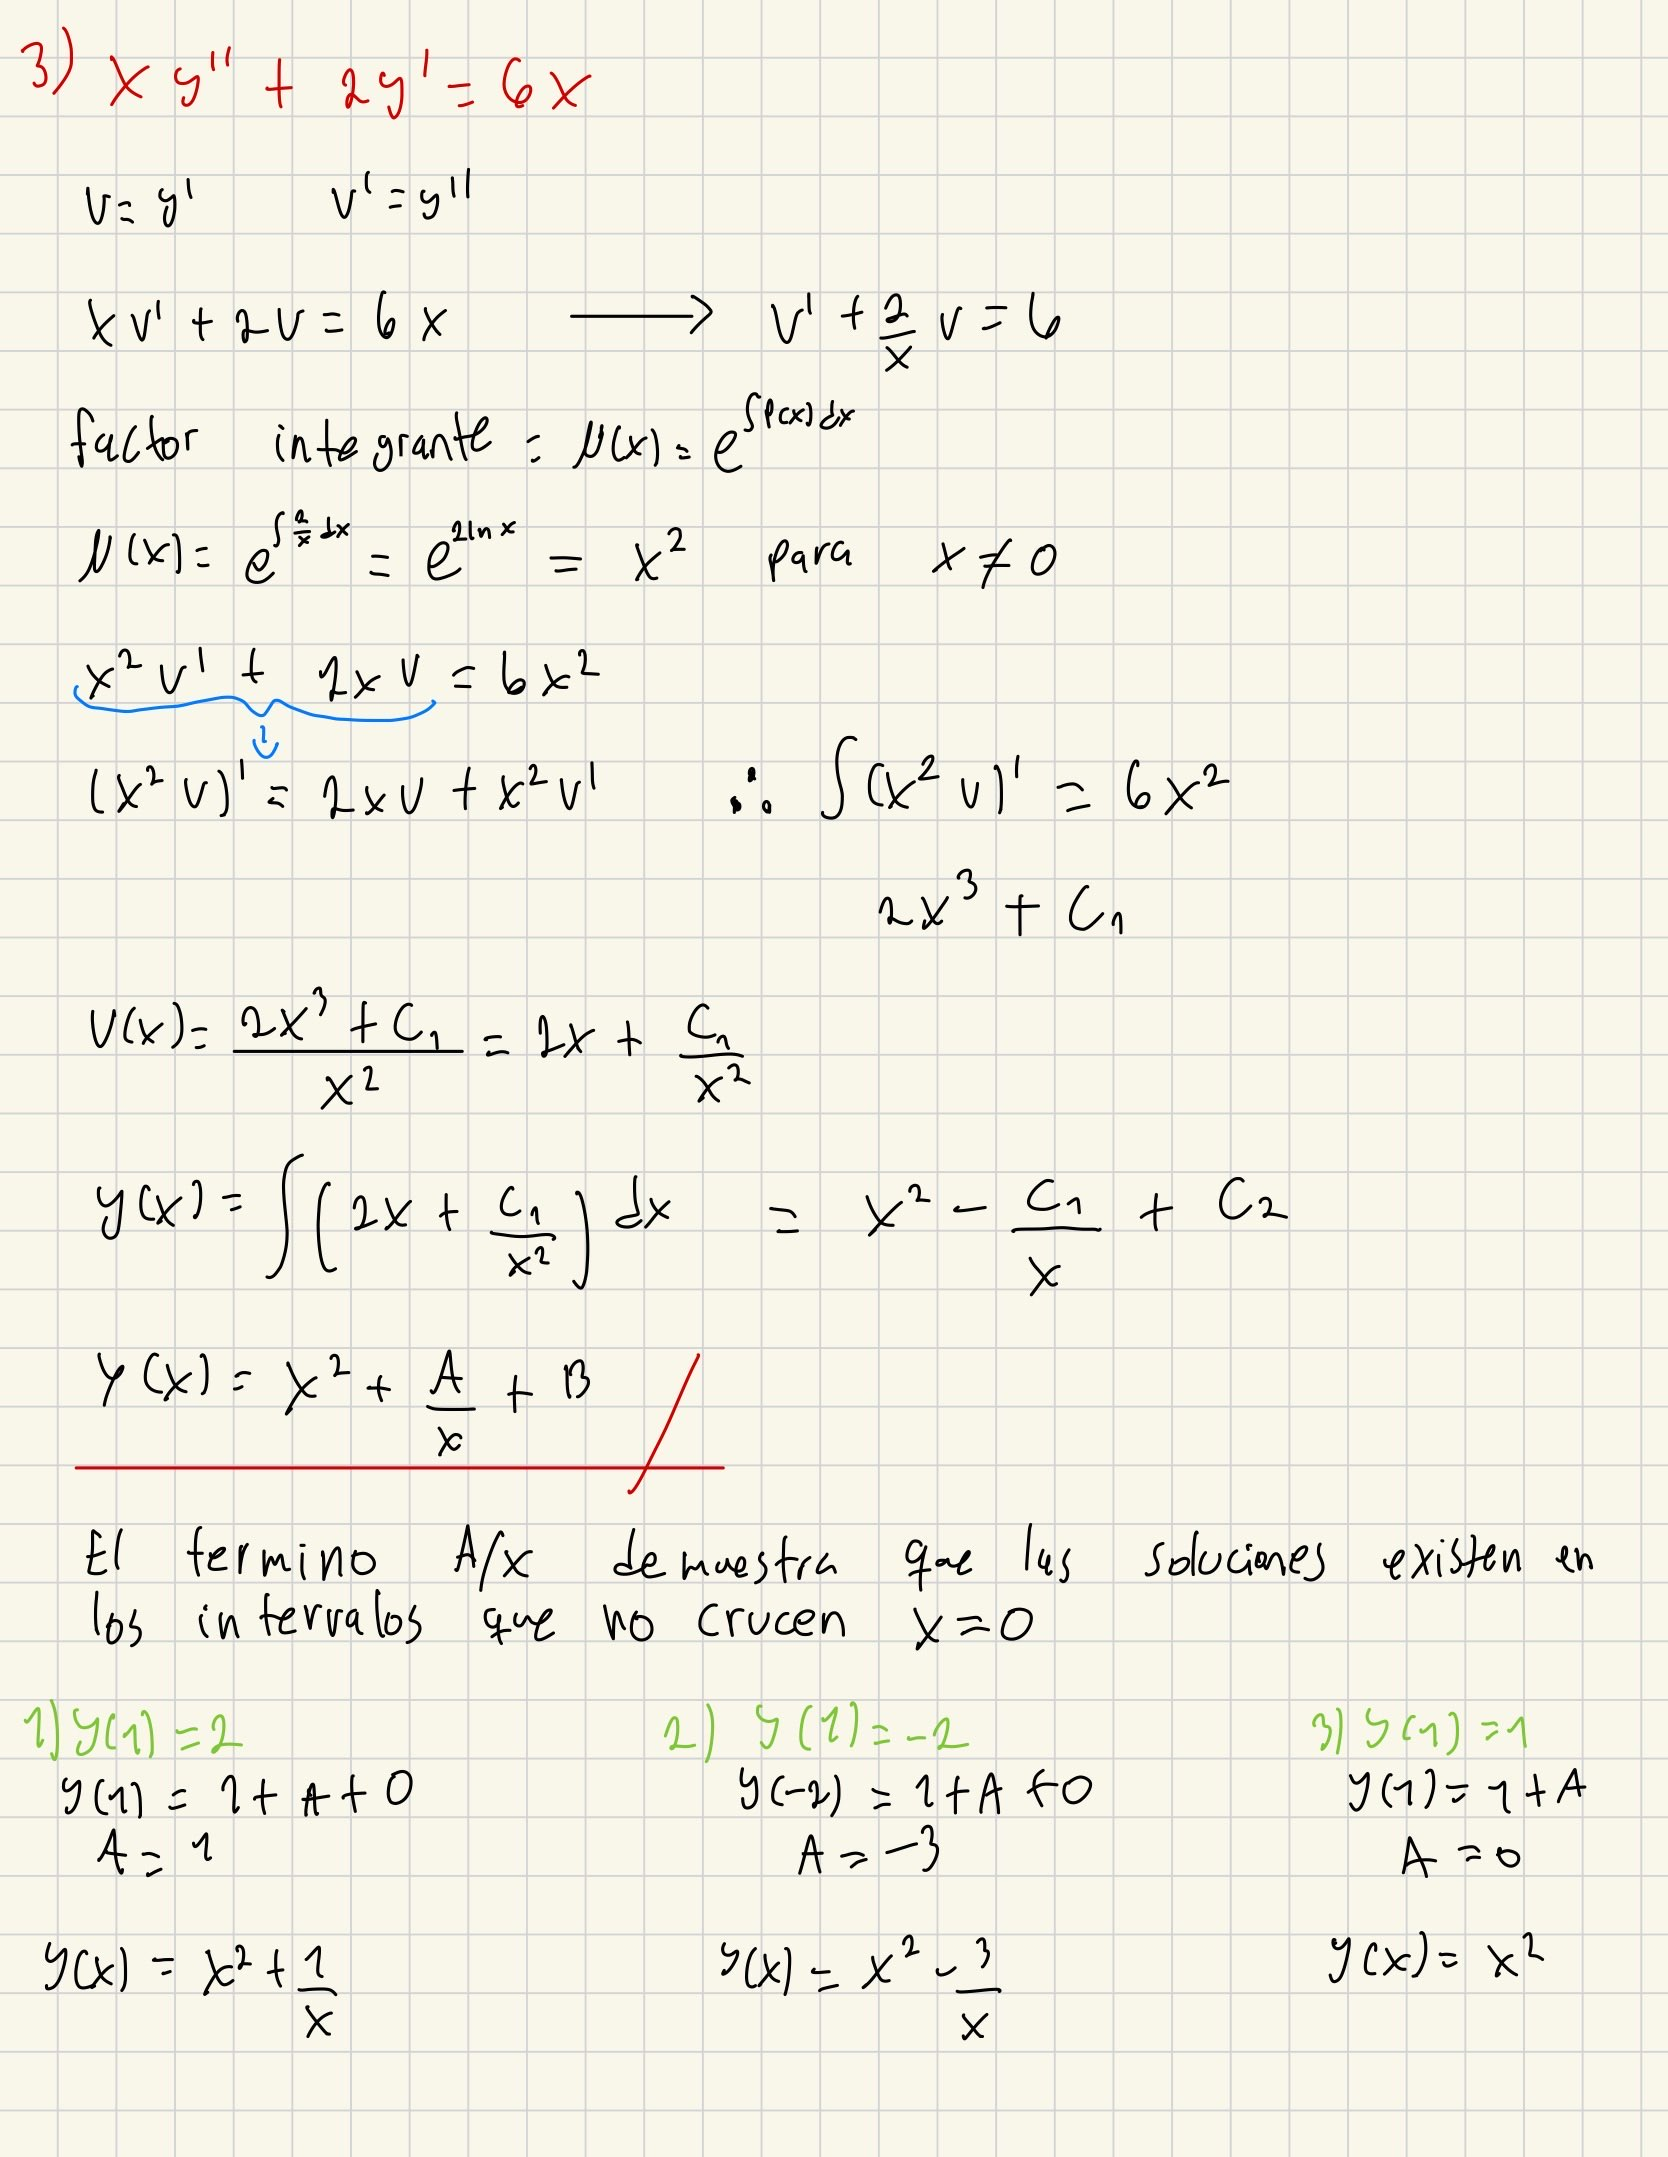
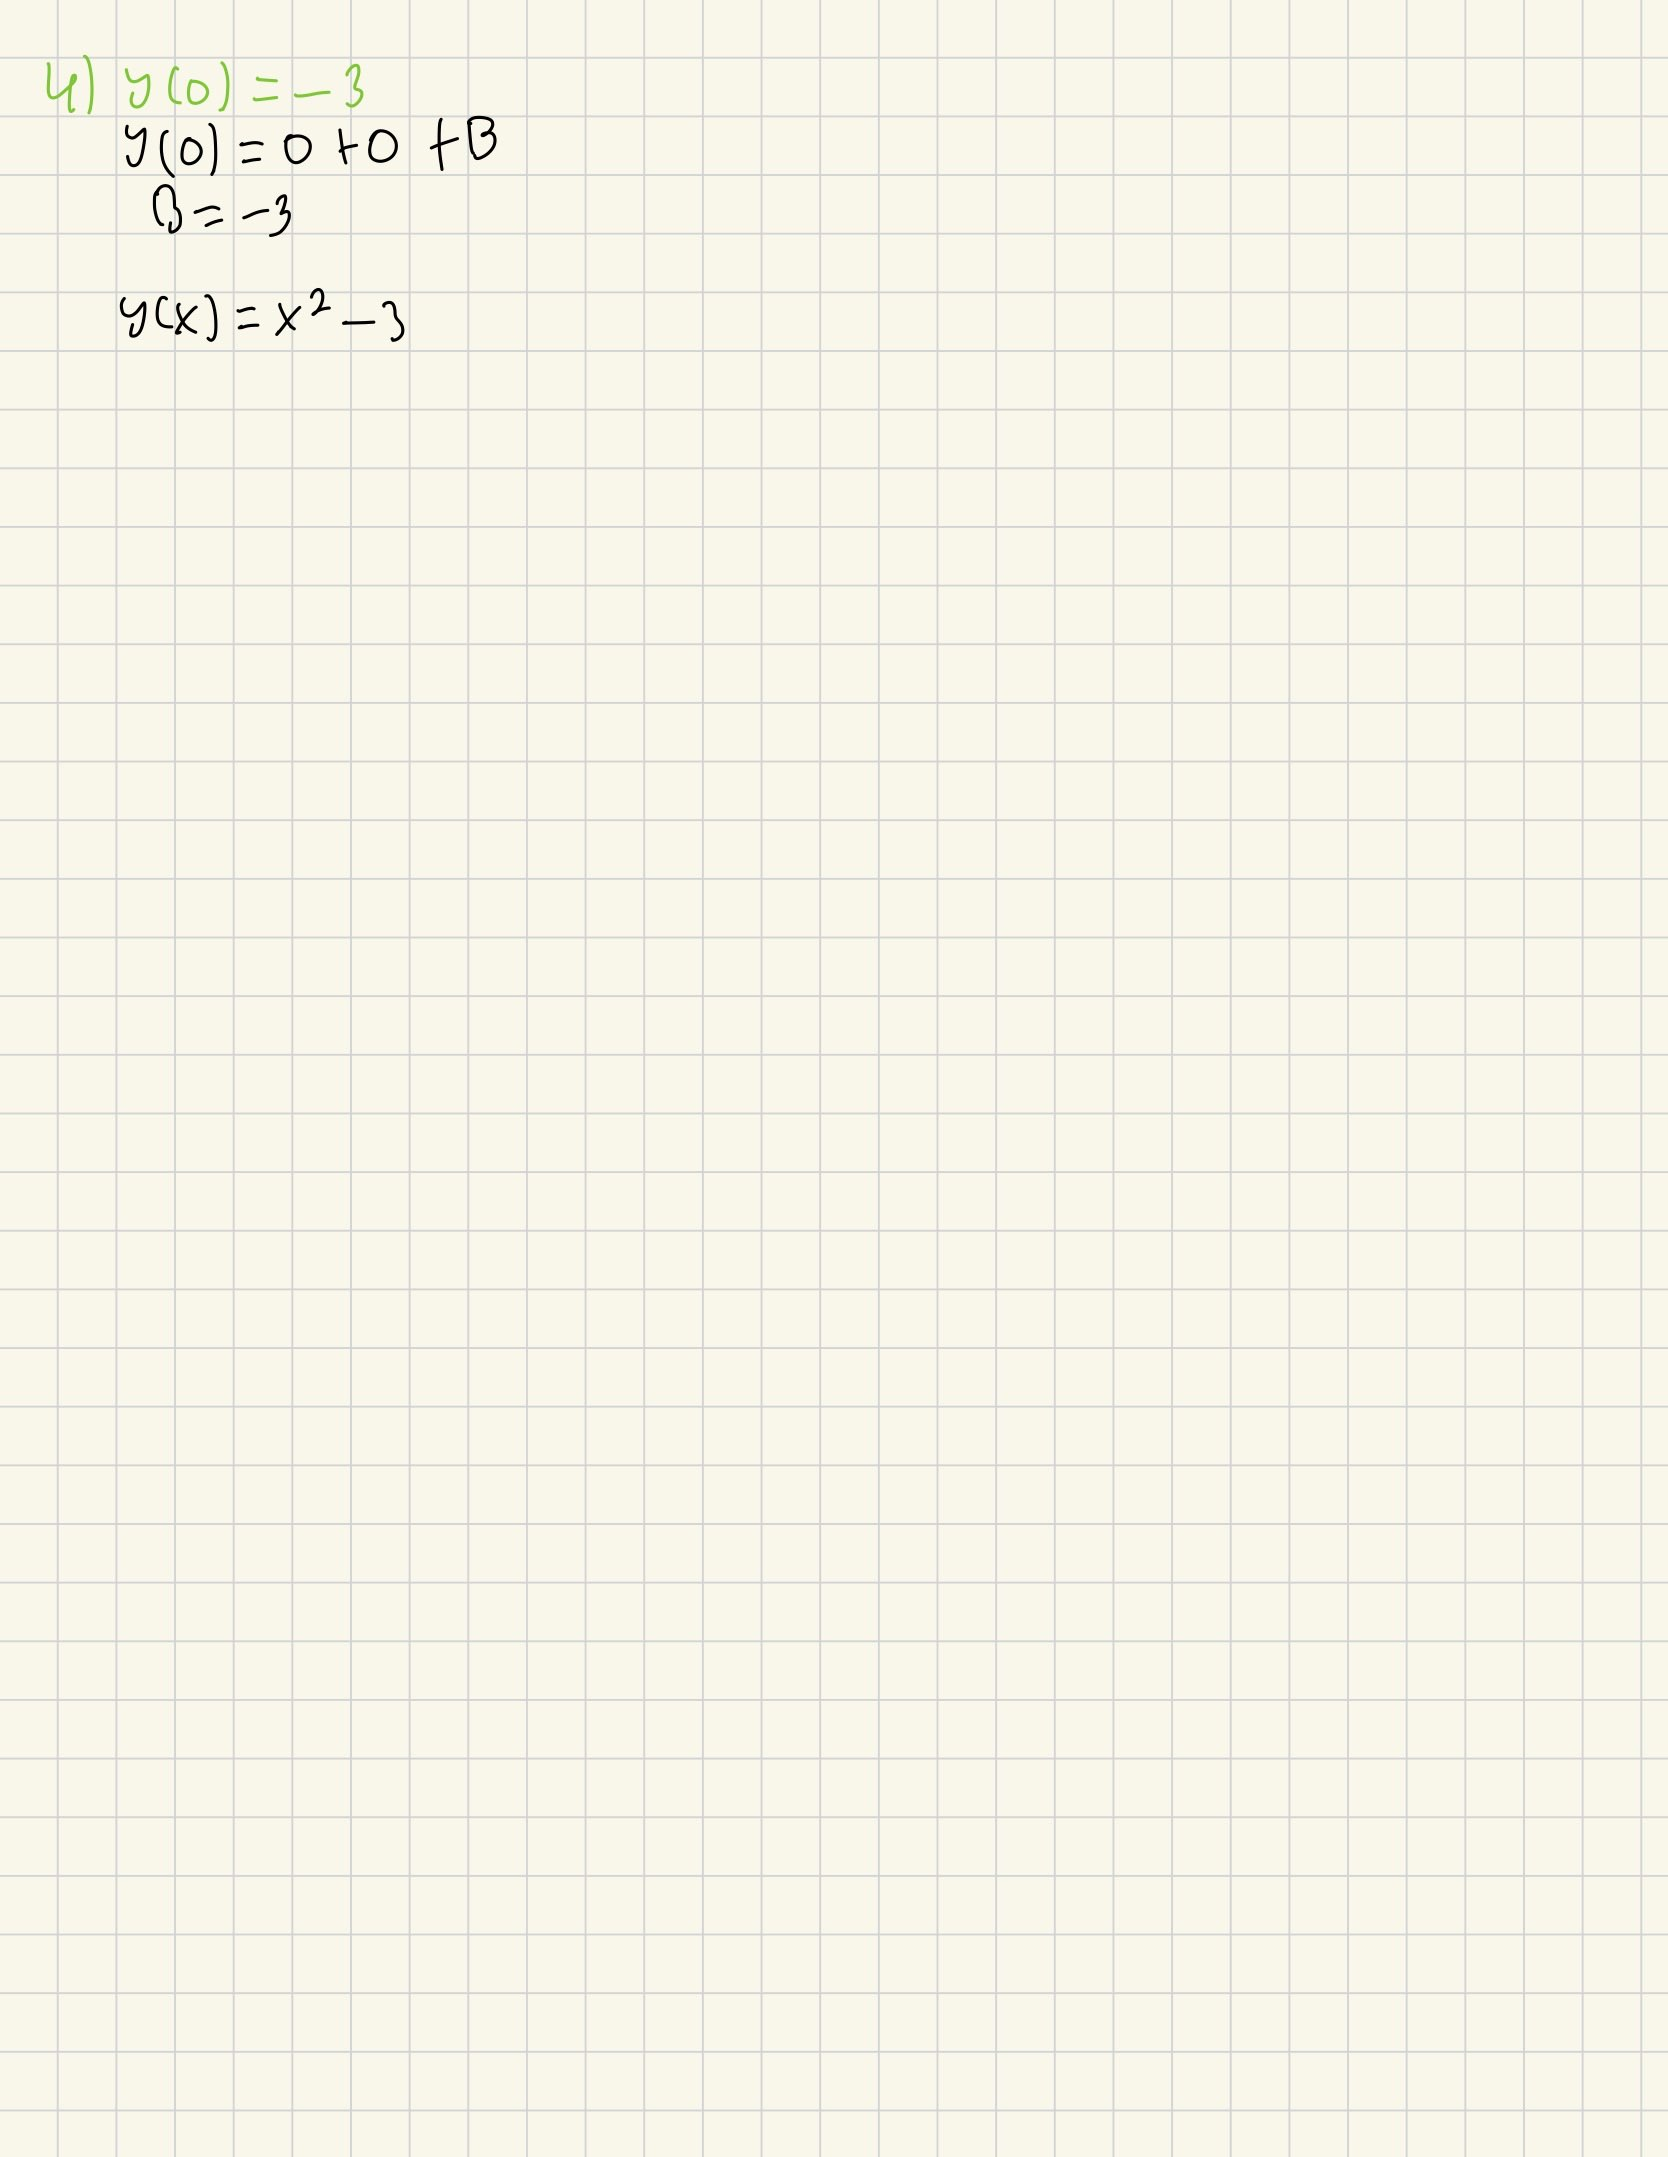

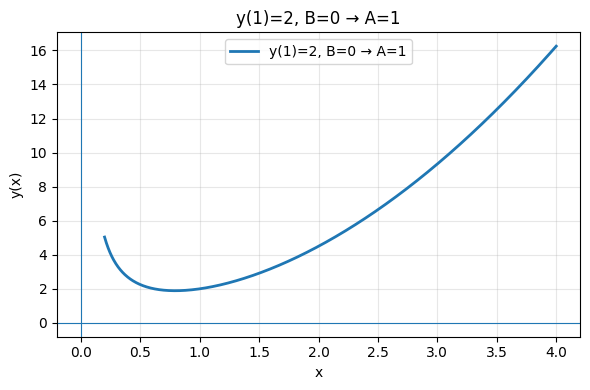

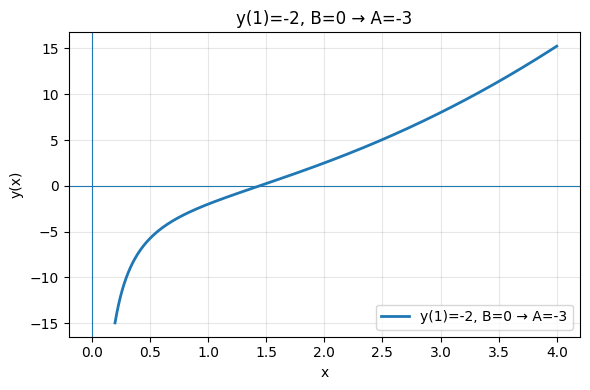

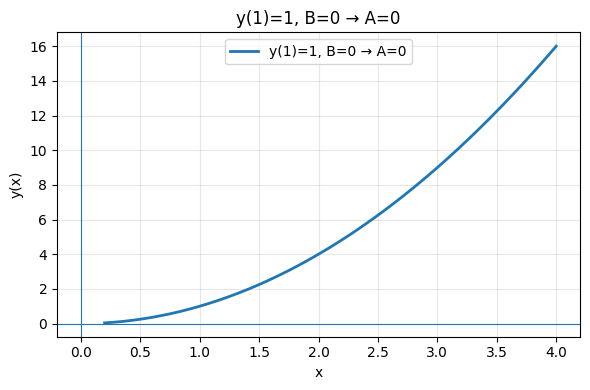

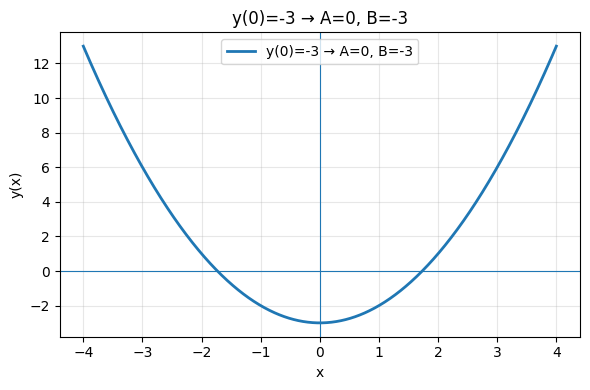

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Solución general: y = x^2 + A/x + B
def y_general(x, A=0.0, B=0.0):
    return x**2 + A/x + B

def plot_case(title, f, x_range, filename):
    xs = np.linspace(x_range[0], x_range[1], 1000)
    ys = f(xs)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, ys, label=title, linewidth=2.0)
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Casos con B=0 y dato en x=1
    # 1) y(1)=2  => 1 + A = 2  -> A = 1
    A1, B1 = 1.0, 0.0
    # 2) y(1)=-2 => 1 + A = -2 -> A = -3
    A2, B2 = -3.0, 0.0
    # 3) y(1)=1  => 1 + A = 1  -> A = 0
    A3, B3 = 0.0, 0.0

    # 4) y(0)=-3: para ser finita en x=0 debe A=0; B=-3
    A4, B4 = 0.0, -3.0

    plot_case(
        "y(1)=2, B=0 → A=1",
        lambda x: y_general(x, A=A1, B=B1),
        (0.2, 4.0),
        "y_1_eq_2_B0_A1.png",
    )

    plot_case(
        "y(1)=-2, B=0 → A=-3",
        lambda x: y_general(x, A=A2, B=B2),
        (0.2, 4.0),
        "y_1_eq_-2_B0_A-3.png",
    )

    plot_case(
        "y(1)=1, B=0 → A=0",
        lambda x: y_general(x, A=A3, B=B3),
        (0.2, 4.0),
        "y_1_eq_1_B0_A0.png",
    )

    plot_case(
        "y(0)=-3 → A=0, B=-3",
        lambda x: y_general(x, A=A4, B=B4),
        (-4.0, 4.0),
        "y_0_eq_-3_A0_B-3.png",
    )


## Ejercicio 4

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Definición del modelo
# ==========================
def N(x, y):
    return x - 3*y - 3*(x**2 - y**2) + 3*x*y

def D(x, y):
    return 2*x - y + 3*(x**2 - y**2) + 2*x*y

def f(x, y):
    den = D(x, y)
    return np.where(np.abs(den) > 1e-12, N(x, y)/den, np.nan)


# ==========================
# Utilidades numéricas
# ==========================
def slope_field(ax, x_min, x_max, y_min, y_max, nx=25, ny=25):
    """Dibuja el campo de direcciones (inciso a)."""
    xs = np.linspace(x_min, x_max, nx)
    ys = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(xs, ys)
    F = f(X, Y)

    U = np.ones_like(F)
    V = F
    norm = np.sqrt(1 + np.nan_to_num(F, nan=0.0)**2)
    Uu = U / norm
    Vv = np.where(np.isfinite(F), V / norm, 0.0)

    ax.quiver(X, Y, Uu, Vv, angles="xy", scale_units="xy",
              scale=0.9, width=0.003, alpha=0.6)
    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.grid(True, alpha=0.3)

def rk4_step(x, y, h, func):
    """Un paso de Runge–Kutta 4 (para inciso b)."""
    k1 = func(x, y)
    k2 = func(x + 0.5*h, y + 0.5*h*k1)
    k3 = func(x + 0.5*h, y + 0.5*h*k2)
    k4 = func(x + h, y + h*k3)
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def integrate_ivp(x0, y0, x_end, h, func, max_slope=1e3):
    """
    Integra y' = func(x,y) de x0 a x_end con RK4.
    Detiene si slope no finita o muy grande (singularidad).
    """
    sign = 1 if x_end >= x0 else -1
    h = abs(h)*sign
    xs = [x0]; ys = [y0]
    x = x0; y = y0
    while (x - x_end)*sign < 0:
        s = func(x, y)
        if not np.isfinite(s) or abs(s) > max_slope:
            break
        x_next = x + h
        y = rk4_step(x, y, h, func)
        x = x_next
        xs.append(x); ys.append(y)
    return np.array(xs), np.array(ys)

def F_vec(z):
    """Campo vectorial 2D para equilibrios (inciso c)."""
    x, y = z
    return np.array([N(x, y), D(x, y)], dtype=float)

def newton2d(z0, tol=1e-10, itmax=50, eps=1e-6):
    """Newton 2D con jacobiano numérico para resolver F_vec(z)=0."""
    z = np.array(z0, dtype=float)
    for _ in range(itmax):
        Fx = F_vec(z)
        if np.linalg.norm(Fx, ord=2) < tol:
            return z, True
        J = np.zeros((2, 2), dtype=float)
        for i in range(2):
            dz = np.zeros(2); dz[i] = eps
            J[:, i] = (F_vec(z + dz) - F_vec(z - dz)) / (2*eps)
        try:
            step = np.linalg.solve(J, -Fx)
        except np.linalg.LinAlgError:
            return z, False
        z = z + step
    return z, False

def find_equilibria(x_range, y_range, m=11, tol_merge=1e-4):
    """Barrido de puntos iniciales y fusión de raíces cercanas."""
    inits_x = np.linspace(x_range[0], x_range[1], m)
    inits_y = np.linspace(y_range[0], y_range[1], m)
    roots = []
    for xi in inits_x:
        for yi in inits_y:
            z, ok = newton2d((xi, yi))
            if ok and np.all(np.isfinite(z)):
                roots.append(z)
    unique = []
    for r in roots:
        if not any(np.linalg.norm(r - u) < tol_merge for u in unique):
            unique.append(r)
    return np.array(unique)


In [4]:
# ==========================
# Parámetros globales
# ==========================
x_min, x_max = -2.0, 2.0
y_min, y_max = -2.0, 2.0
x0, y0 = 1.5, 0.0  

INCISO (a): Graficando el campo de direcciones de y' = f(x,y) ...


C:\Users\thiag\AppData\Local\Temp\ipykernel_13760\2787886122.py:15: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(den) > 1e-12, N(x, y)/den, np.nan)
C:\Users\thiag\AppData\Local\Temp\ipykernel_13760\2787886122.py:15: RuntimeWarning: invalid value encountered in divide
  return np.where(np.abs(den) > 1e-12, N(x, y)/den, np.nan)


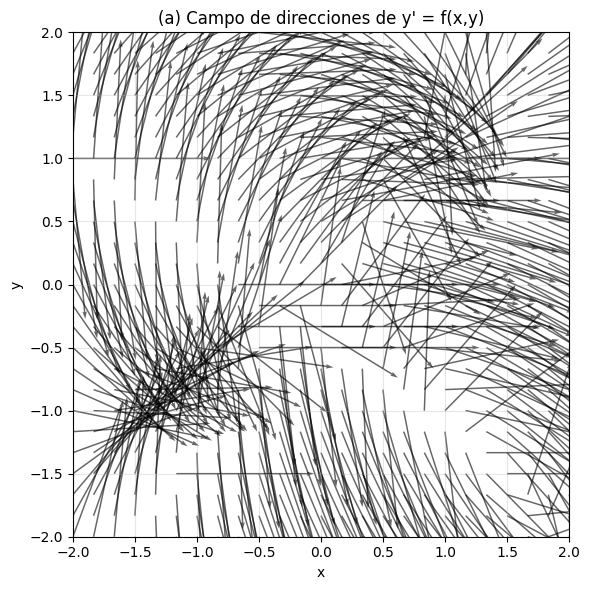

In [5]:
# ==========================
# INCISO (a): Campo de direcciones
# ==========================
print("INCISO (a): Graficando el campo de direcciones de y' = f(x,y) ...")
fig_a, ax_a = plt.subplots(figsize=(6, 6))
slope_field(ax_a, x_min, x_max, y_min, y_max, nx=25, ny=25)
ax_a.set_title("(a) Campo de direcciones de y' = f(x,y)")
plt.tight_layout()
plt.show()

INCISO (b): Integrando el PVI y(1.5)=0 con RK4 y superponiendo al campo ...


C:\Users\thiag\AppData\Local\Temp\ipykernel_13760\2787886122.py:15: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(den) > 1e-12, N(x, y)/den, np.nan)
C:\Users\thiag\AppData\Local\Temp\ipykernel_13760\2787886122.py:15: RuntimeWarning: invalid value encountered in divide
  return np.where(np.abs(den) > 1e-12, N(x, y)/den, np.nan)


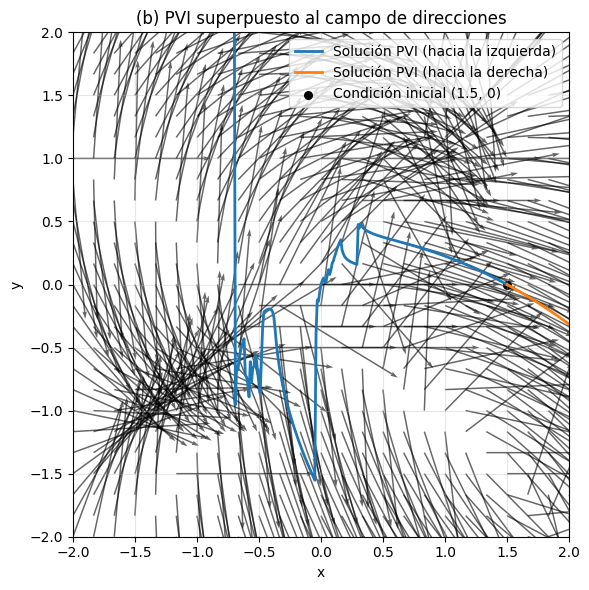

INCISO (b): Segmentos computados: izquierda=351 puntos, derecha=51 puntos.


In [6]:

# ==========================
# INCISO (b): Solución del PVI y(1.5)=0
# ==========================
print("INCISO (b): Integrando el PVI y(1.5)=0 con RK4 y superponiendo al campo ...")
# Integramos hacia la derecha (x0 -> x_max) y hacia la izquierda (x0 -> x_min)
xs_r, ys_r = integrate_ivp(x0, y0, x_max, 0.01, f)
xs_l, ys_l = integrate_ivp(x0, y0, x_min, 0.01, f)

fig_b, ax_b = plt.subplots(figsize=(6, 6))
slope_field(ax_b, x_min, x_max, y_min, y_max, nx=25, ny=25)
ax_b.plot(xs_l, ys_l, lw=2, label="Solución PVI (hacia la izquierda)")
ax_b.plot(xs_r, ys_r, lw=2, label="Solución PVI (hacia la derecha)")
ax_b.scatter([x0], [y0], c="k", s=30, label="Condición inicial (1.5, 0)")
ax_b.set_title("(b) PVI superpuesto al campo de direcciones")
ax_b.legend()
plt.tight_layout()
plt.show()

print(f"INCISO (b): Segmentos computados: izquierda={len(xs_l)} puntos, derecha={len(xs_r)} puntos.")
if len(xs_l) == 0 or len(xs_r) == 0:
    print("INCISO (b): Advertencia: integración detenida cerca de una singularidad (denominador D≈0 o |f| grande).")

INCISO (c): Buscando puntos de equilibrio resolviendo el sistema N=0, D=0 ...


C:\Users\thiag\AppData\Local\Temp\ipykernel_13760\2787886122.py:15: RuntimeWarning: divide by zero encountered in divide
  return np.where(np.abs(den) > 1e-12, N(x, y)/den, np.nan)
C:\Users\thiag\AppData\Local\Temp\ipykernel_13760\2787886122.py:15: RuntimeWarning: invalid value encountered in divide
  return np.where(np.abs(den) > 1e-12, N(x, y)/den, np.nan)


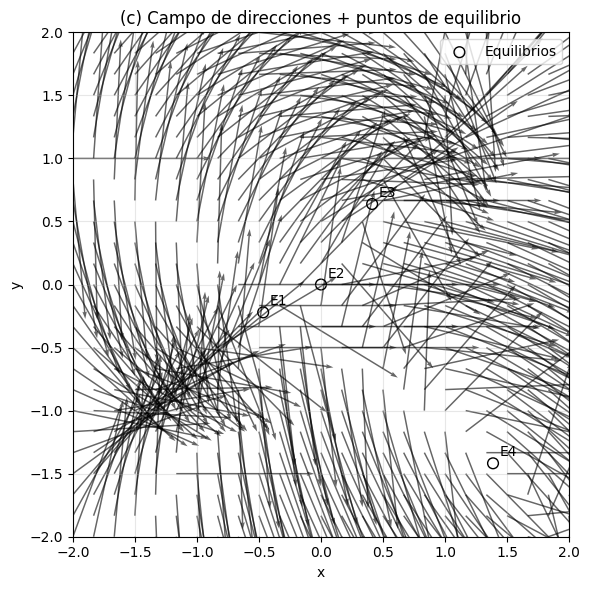

INCISO (c): Equilibrios encontrados (x, y) =
[[-4.66121209e-01 -2.20889377e-01]
 [ 6.38465913e-15  2.20006645e-15]
 [ 4.12477949e-01  6.38639191e-01]
 [ 1.38697659e+00 -1.41774981e+00]]


In [7]:
# ==========================
# INCISO (c): Puntos de equilibrio F(x,y) = (0,0)
# ==========================
print("INCISO (c): Buscando puntos de equilibrio resolviendo el sistema N=0, D=0 ...")
eq = find_equilibria((x_min, x_max), (y_min, y_max), m=13)  # m más denso para mayor cobertura

fig_c, ax_c = plt.subplots(figsize=(6, 6))
slope_field(ax_c, x_min, x_max, y_min, y_max, nx=25, ny=25)
if eq.size:
    ax_c.scatter(eq[:, 0], eq[:, 1], s=60, marker="o",
                 edgecolor="k", facecolor="none", label="Equilibrios")
    # Etiquetas E1, E2, ...
    for i, (xe, ye) in enumerate(eq):
        ax_c.annotate(f"E{i+1}", (xe, ye), xytext=(5, 5), textcoords="offset points")
    ax_c.legend()
ax_c.set_title("(c) Campo de direcciones + puntos de equilibrio")
plt.tight_layout()
plt.show()

print("INCISO (c): Equilibrios encontrados (x, y) =")
print(eq if eq.size else "Ninguno en el rango muestreado.")

## Ejercicio 5

p = 